#### Modules

In [87]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

#### Convert categorical columns into numerical columns

In [111]:
#Upload dataset (we are not using carbon emission and fule comsumption comb as features)
df = pd.read_csv('Clean dataset.csv')
df = df.drop(columns = ['CO2 Emissions(g/km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)'])

# Specical case for transmission (e.g. Separate AS5 to AS and 5, 5 stored as gear number for the car, for AV gear number will be zero)
df['Transmission Type'] = df['Transmission'].str.extract(r'([A-Za-z]+)')
df['Gear num'] = df['Transmission'].str.extract(r'(\d+)').astype(float)
df = df.fillna(0)
df = df.drop(columns = ['Transmission'])

# One Hot Encoding for all categorical features
cat_cols = ['Vehicle Class', 'Transmission Type', 'Fuel Type']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)

# Define targets and features
city = df['Fuel Consumption City (L/100 km)']
hwy = df['Fuel Consumption Hwy (L/100 km)']
feat = df.drop(columns = ['Fuel Consumption City (L/100 km)','Fuel Consumption Hwy (L/100 km)'])
feat_col = feat.columns

# Rearrange column position and brief view of dataset
col1, col2 = 'Fuel Consumption City (L/100 km)','Fuel Consumption Hwy (L/100 km)'
col1 = [c for c in df.columns if c != col1] + [col1]
col2 = [c for c in col1 if c != col2] + [col2]
df = df[col2]
df.describe()

,Engine Size(L),Cylinders,Gear num,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,Vehicle Class_MINICOMPACT,Vehicle Class_MINIVAN,Vehicle Class_PICKUP TRUCK - SMALL,Vehicle Class_PICKUP TRUCK - STANDARD,Vehicle Class_SPECIAL PURPOSE VEHICLE,...,Transmission Type_AM,Transmission Type_AS,Transmission Type_AV,Transmission Type_M,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km)
count,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,...,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000,4932.000000
mean,3.071269,5.505474,6.584955,0.074615,0.170114,0.038524,0.010543,0.017234,0.073398,0.009530,...,0.082117,0.462490,0.084550,0.161598,0.047648,0.000203,0.497972,0.430251,12.370337,8.926683
std,1.329289,1.823307,1.837188,0.262795,0.375771,0.192477,0.102149,0.130157,0.260815,0.097163,...,0.274570,0.498642,0.278239,0.368119,0.213042,0.014239,0.500047,0.495161,3.462994,2.230060
min,0.900000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,4.000000
25%,2.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.900000,7.375000
50%,3.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.900000,8.500000
75%,3.600000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,14.300000,10.000000
max,8.400000,16.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.600000,20.600000


#### Scatter plots for Fuel consumption city and Fuel consumption highway

In [ ]:
plt.figure(figsize=(20, 20))
for idx , col in enumerate(feat_col):
    plt.subplot(5, 6, idx + 1)
    sns.scatterplot(data = df, x = col, y = city.name, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(city.name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 20))
for idx , col in enumerate(feat_col):
    plt.subplot(5, 6, idx + 1)
    sns.scatterplot(data = df, x = col, y = hwy.name, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(hwy.name)
plt.tight_layout()
plt.show()

#### Split train and test set & standardscaler features

In [60]:
# Split the data into training and testing sets (80% train, 20% test)
xc_train, xc_test, c_tr, c_te = train_test_split(feat, city, test_size=0.2, random_state=42)
xh_train, xh_test, h_tr, h_te = train_test_split(feat, hwy, test_size=0.2, random_state=42)

#Normalize the X data
scaler = StandardScaler()
xc_tr, xc_te  = scaler.fit_transform(xc_train) , scaler.fit_transform(xc_test)
xh_tr, xh_te  = scaler.fit_transform(xh_train) , scaler.fit_transform(xh_test)

#### Fitting the model with linear regression (adequate performance)

In [ ]:
# Model fitting using linear regression
lg = LinearRegression()

# City Linear regression model
l_c = lg.fit(xc_tr, c_tr)
c_pred = l_c.predict(xc_te)
c_r2 = r2_score(c_te, c_pred)
c_rmse = root_mean_squared_error(c_te, c_pred)
print(f"R2 for city model: {c_r2}")
print(f"RMSE for city model: {c_rmse}\n")

# Highway Linear regression model
l_h= lg.fit(xh_tr, h_tr)
h_pred = l_h.predict(xh_te)
h_r2 = r2_score(h_te, h_pred)
h_rmse = root_mean_squared_error(h_te, h_pred)
print(f"R2 for highway model: {h_r2}")
print(f"RMSE for highway model: {h_rmse}")

R2 for city model: 0.8629748032052107
RMSE for city model: 1.3136740345515994

R2 for highway model: 0.8576920309752225
RMSE for highway model: 0.8560306092972879


#### Pearson correlation heat maps

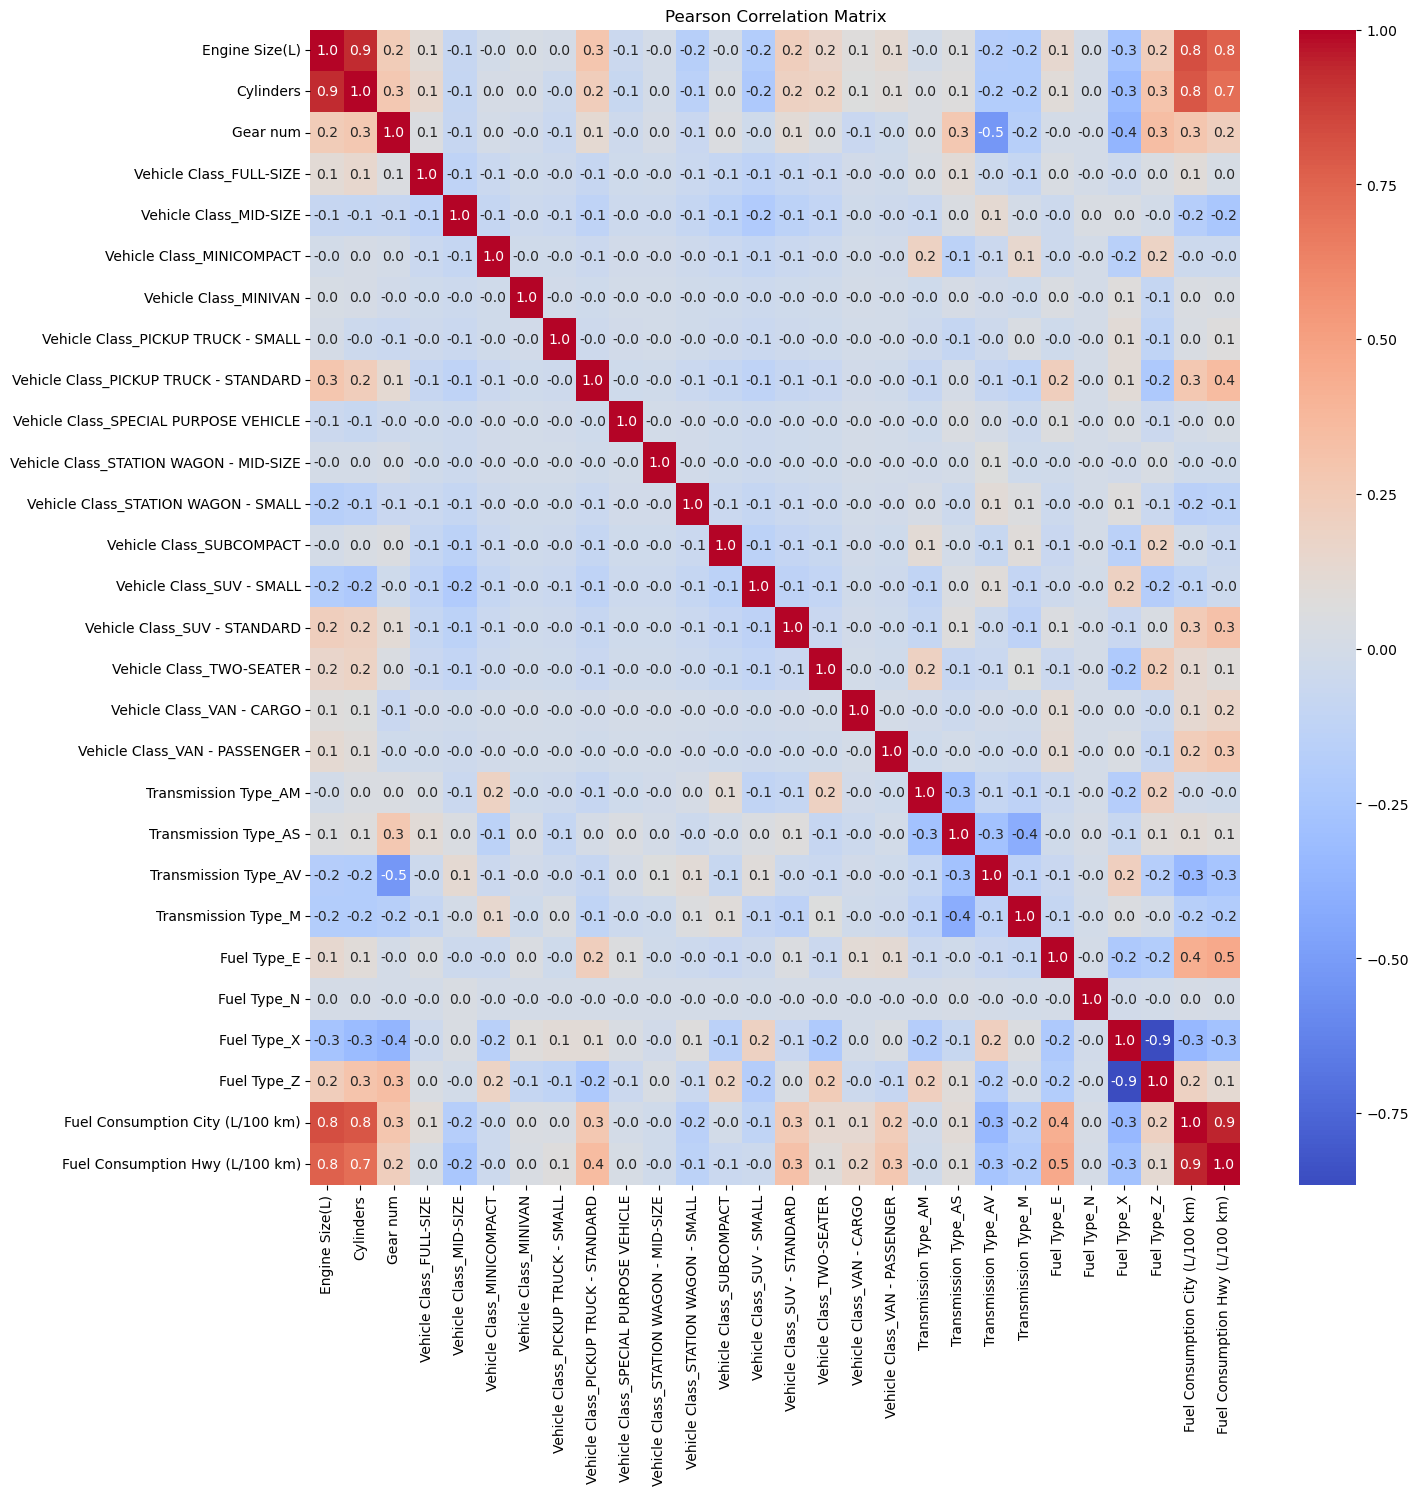

In [123]:
# Plot the heatmap using the sns.heatmap function (features are not correlated with each other)
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot = True, fmt = ".1f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

In [122]:
# Correlation with city
print(f'Correlation for city : \n{np.abs(df.corr()['Fuel Consumption City (L/100 km)']).sort_values(ascending=False)}\n\n')

# Correlation with highway
print(f'Correlation for highway : \n{np.abs(df.corr()['Fuel Consumption Hwy (L/100 km)']).sort_values(ascending=False)}')

Correlation for city : 
Fuel Consumption City (L/100 km)          1.000000
Fuel Consumption Hwy (L/100 km)           0.947899
Engine Size(L)                            0.828350
Cylinders                                 0.798763
Fuel Type_E                               0.425401
Fuel Type_X                               0.342384
Transmission Type_AV                      0.337183
Gear num                                  0.286208
Vehicle Class_PICKUP TRUCK - STANDARD     0.277531
Vehicle Class_SUV - STANDARD              0.254511
Vehicle Class_VAN - PASSENGER             0.238809
Fuel Type_Z                               0.198447
Vehicle Class_MID-SIZE                    0.177197
Transmission Type_M                       0.166570
Vehicle Class_STATION WAGON - SMALL       0.154097
Vehicle Class_TWO-SEATER                  0.128907
Vehicle Class_VAN - CARGO                 0.125934
Vehicle Class_SUV - SMALL                 0.117866
Transmission Type_AS                      0.100973
Vehicle

#### Recursive Feature Elimination

In [93]:
# cross validation to find the optimal number of features
kf = KFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=lg, step=1, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

#RFE using random forest regressor for city model 
selector.fit(xc_tr, c_tr)
sel_list_c = selector.support_
feat_rk_c = selector.ranking_
sel_feat_c = xc_train.columns[sel_list_c].to_list()
print(f'Number of features for city model : {len(feat_col)}')
print(f"Selected Features for city model: {len(sel_feat_c)}\n")
print(pd.DataFrame({'Feature': feat_col, 'Ranking': feat_rk_c }).sort_values(by='Ranking'))

#RFE using random forest regressor for highway model
selector.fit(xh_tr, h_tr)
sel_list_h = selector.support_
feat_rk_h = selector.ranking_
sel_feat_h = xh_train.columns[sel_list_h].to_list()
print(f'\nNumber of features for highway model : {len(feat_col)}')
print(f"Selected Features for highway model: {len(sel_feat_h)}\n")
print(pd.DataFrame({'Feature': feat_col, 'Ranking': feat_rk_h }).sort_values(by='Ranking'))

Number of features for city model : 26
Selected Features for city model: 22

                                   Feature  Ranking
0                           Engine Size(L)        1
1                                Cylinders        1
3                  Vehicle Class_FULL-SIZE        1
5                Vehicle Class_MINICOMPACT        1
7       Vehicle Class_PICKUP TRUCK - SMALL        1
6                    Vehicle Class_MINIVAN        1
9    Vehicle Class_SPECIAL PURPOSE VEHICLE        1
8    Vehicle Class_PICKUP TRUCK - STANDARD        1
14            Vehicle Class_SUV - STANDARD        1
13               Vehicle Class_SUV - SMALL        1
11     Vehicle Class_STATION WAGON - SMALL        1
12                Vehicle Class_SUBCOMPACT        1
15                Vehicle Class_TWO-SEATER        1
19                    Transmission Type_AS        1
17           Vehicle Class_VAN - PASSENGER        1
16               Vehicle Class_VAN - CARGO        1
25                             Fuel Typ

#### Use Lasso to find the most important feature

In [102]:
#Find the best alpha values for both models
lasso_cv = LassoCV(alphas=None, cv=kf, max_iter=10000, n_jobs=-1, random_state=42)
c_alpha = lasso_cv.fit(xc_tr, c_tr).alpha_
print(f'Best alpha for city lasso : {c_alpha}')
h_alpha = lasso_cv.fit(xh_tr, h_tr).alpha_
print(f'Best alpha for highway lasso : {h_alpha}\n')

# Lasso for city model
la_c = Lasso(max_iter=10000, alpha=c_alpha).fit(xc_tr, c_tr)
c_pred_lasso = la_c.predict(xc_te)
c_r2_lasso = r2_score(c_te, c_pred_lasso)
c_rmse_lasso = root_mean_squared_error(c_te, c_pred_lasso)
print(f"Lasso R2 for city model: {c_r2_lasso}")
print(f"Lasso RMSE for city model: {c_rmse_lasso}\n")
c_coef = la_c.coef_

# Lasso for highway model
la_h = Lasso(max_iter=10000, alpha=h_alpha).fit(xh_tr, h_tr)
h_pred_lasso = la_h.predict(xh_te)
h_r2_lasso = r2_score(h_te, h_pred_lasso)
h_rmse_lasso = root_mean_squared_error(h_te, h_pred_lasso)
print(f"Lasso R2 for city model: {h_r2_lasso}")
print(f"Lasso RMSE for city model: {h_rmse_lasso}")
h_coef = la_h.coef_

Best alpha for city lasso : 0.0028459187796775675
Best alpha for highway lasso : 0.0016782957790944194

Lasso R2 for city model: 0.86298135242287
Lasso RMSE for city model: 1.313642640179643

Lasso R2 for city model: 0.8578970304619224
Lasso RMSE for city model: 0.8554138164338836


#### Plotting coefficient values

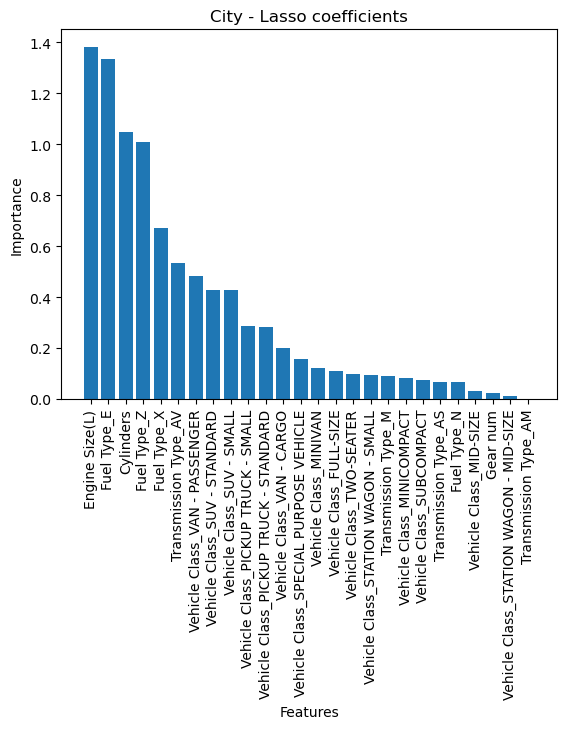

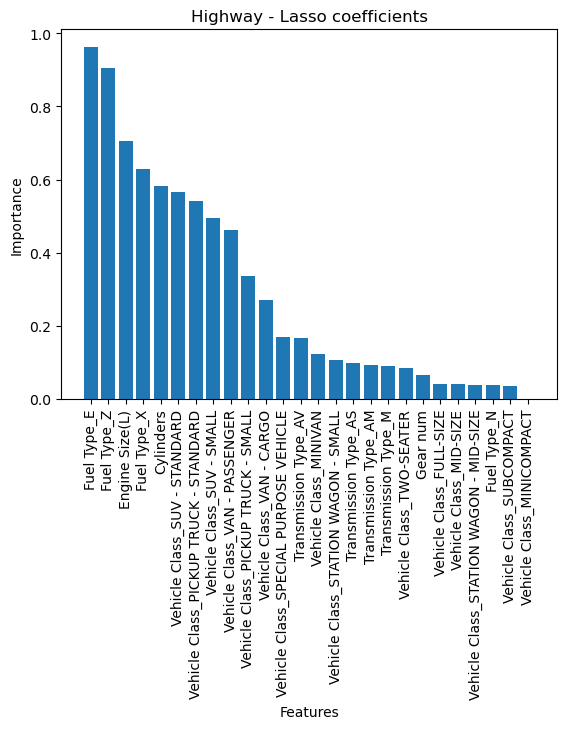

In [96]:
# Coefficients of city lasso
df_c = pd.DataFrame({'Feature': feat_col, 'Coefficients': np.abs(c_coef) }).sort_values(by='Coefficients', ascending=False)
plt.bar(df_c['Feature'], df_c['Coefficients'])
plt.xticks(rotation=90)
plt.title("City - Lasso coefficients")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Coefficients of highway lasso
df_h = pd.DataFrame({'Feature': feat_col, 'Coefficients': np.abs(h_coef) }).sort_values(by='Coefficients', ascending=False)
plt.bar(df_h['Feature'], df_h['Coefficients'])
plt.xticks(rotation=90)
plt.title("Highway - Lasso coefficients")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

#### Conclusion:

1. Results between RFE and Lasso are in strong agreement

2. Transmission Type_AM is not important for city prediction

3. Vehicle Class_ MINICOMPACT is not important for highway prediction